In [1]:
# Download the dataset.
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o ./trainDevTestTrees_PTB.zip
!unzip -q -o -d ./ ./trainDevTestTrees_PTB.zip
!rm -f ./trainDevTestTrees_PTB.zip

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch import nn
def loadsst(path):
    xs = []
    ys = []
    with open(path, 'r') as file:
        # Quick, dirty, and improper S-expression parsing.
        for line in file.readlines():
            soup = line.split()
            ys.append(int(soup[0].lstrip('(')))
            tokens = []
            for chunk in soup[2:]:
                if not chunk.endswith(")"):
                    continue
                tokens.append(chunk.rstrip( ')'))
            xs.append(tokens)
    return xs, ys

ssttrainxs, ssttrainys = loadsst("./trees/train.txt")
sstvalidxs, sstvalidys = loadsst("./trees/dev.txt")
ssttestxs, ssttestys   = loadsst("./trees/test.txt")

In [3]:
  #Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#Alphabet creation
corpus = ''.join( ' '.join(s) for s in ssttrainxs + ssttestxs + sstvalidxs)
alphabet = list(set(corpus))
#character to value dictionnary
char2val= {}
for i in range(len(alphabet)):
  char2val[alphabet[i]] = i

#Joining all the sentences together 
ssttrainxs =  ''.join( ' '.join(s) for s in ssttrainxs)
sstvalidxs =  ''.join( ' '.join(s) for s in sstvalidxs)
ssttestxs =  ''.join( ' '.join(s) for s in ssttestxs)

#changing character to their value correspondant reffering to the alphabet
ssttrainxs = [char2val[char] for char in ssttrainxs]
sstvalidxs = [char2val[char] for char in sstvalidxs]
ssttestxs = [char2val[char] for char in ssttestxs]

In [5]:
# Hyper-parameters 
batch_size = 64
sequence_length = 128 
hidden_size = 512
num_layers = 2    
num_epochs = 64
learning_rate = 0.001
mlp_layers = 2
MLP1 = 256
MLP2 = 256


input_size = len(alphabet) #one hot label encoding vector 
num_classes = len(alphabet)
Data_length = int(len(ssttrainxs) / sequence_length)

dev_length = int(len(sstvalidxs) / sequence_length)
test_length = int(len(ssttestxs) / sequence_length)


In [6]:
'''Slicing the inputs for later use of batches'''

#ensuring the last element sentence has the same sequence_length
if len(ssttrainxs) % sequence_length != 0:
  cut = len(ssttrainxs) % sequence_length
  ssttrainxs[:-cut]

if len(ssttestxs) % sequence_length != 0:
  cut = len(ssttestxs) % sequence_length
  ssttestxs[:-cut]

if len(sstvalidxs) % sequence_length != 0:
  cut = len(sstvalidxs) % sequence_length
  sstvalidxs[:-cut]

#slicing in sequence_length size// 
trainX = [ssttrainxs[(i*sequence_length - sequence_length):(i*sequence_length - 1)] for i in range(1, Data_length + 1)]
testX = [ssttestxs[(i*sequence_length - sequence_length):(i*sequence_length - 1)] for i in range(1, test_length + 1)]
devX = [sstvalidxs[(i*sequence_length - sequence_length):(i*sequence_length - 1)] for i in range(1, dev_length + 1)]

#Creating  output
trainY = [ssttrainxs[(i*sequence_length - sequence_length + 1):(i*sequence_length)] for i in range(1, Data_length + 1)]
devY = [sstvalidxs[(i*sequence_length - sequence_length + 1):(i*sequence_length)] for i in range(1, dev_length + 1)]
testY = [ssttestxs[(i*sequence_length - sequence_length + 1):(i*sequence_length)] for i in range(1, test_length + 1)]

In [7]:
#one hot encoding
def one_hot_encoding(training_data, dict_size, seq_len, batch_size):
    # Creating zeros array
    ohe_matrix = np.zeros((batch_size, seq_len - 1, dict_size), dtype=np.float32)
    # inputing the 1 in the right index for ohe
    for i in range(batch_size):
      for u in range(seq_len - 1):      
        ohe_matrix[i, u, training_data[i][u]] = 1
    return ohe_matrix

training_input = torch.from_numpy(one_hot_encoding(trainX, num_classes, sequence_length, Data_length))
training_output = torch.Tensor(trainY)

dev_input = torch.from_numpy(one_hot_encoding(devX, num_classes, sequence_length, dev_length))
dev_output = torch.Tensor(devY)

testing_input = torch.from_numpy(one_hot_encoding(testX, num_classes, sequence_length, test_length))
testing_output = torch.Tensor(testY)

In [8]:
import torch.utils.data as data
#use Data loader to generate Data and concatenate inputs and labels
training_data = data.DataLoader(np.dstack((training_input, training_output)), batch_size)
dev_data = data.DataLoader(np.dstack((dev_input, dev_output)), batch_size)
test_data = data.DataLoader(np.dstack((testing_input, testing_output)), batch_size)

In [9]:
#Vanilla RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)       

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        hidden.to(device)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.rnn(x.to(device), hidden.to(device))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        
        return out
        
    def init_hidden(self, batch_size):
      # This method generates the first hidden state of zeros which we'll use in the forward pass
      # We'll send the tensor holding the hidden state to the device we specified earlier as well
      hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
      return hidden

rnn_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
def correct(y_pred, y):
  prediction_idx = torch.argmax(y_pred, dim=1)
  correct = torch.sum(prediction_idx == y)
  return correct

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate) 

# Train the model
for epoch in range(num_epochs):
  corrects = 0
  for iter_data in training_data:
    X = iter_data[:, :, :-1]
    Y = iter_data[:, :, -1]
    optimizer.zero_grad()
    X.to(device)
    output_training = rnn_model(X)   
    output_training.to(device)
    corrects += correct(output_training, Y.view(-1).long().to(device))
    loss = criterion(output_training, Y.view(-1).long().to(device))     #loss = criterion(outputs, labels)
    loss.backward()  #Backpropagation
    optimizer.step()

In [ ]:
#GRU 
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        hidden.to(device)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.gru(x.to(device), hidden.to(device))       
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)
        
        return out
        
    def init_hidden(self, batch_size):
      # This method generates the first hidden state of zeros which we'll use in the forward pass
      #  send the tensor holding the hidden state to the device specified earlier as well
      hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
      return hidden

gru_model = GRU(input_size, hidden_size, num_layers, num_classes).to(device)
def correct(y_pred, y):
  prediction_idx = torch.argmax(y_pred, dim=1)
  correct = torch.sum(prediction_idx == y)
  return correct

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate) 

# Train the model
for epoch in range(num_epochs):
  corrects = 0
  for iter_data in training_data:
    X = iter_data[:, :, :-1]
    Y = iter_data[:, :, -1]
    optimizer.zero_grad()
    X.to(device)
    output_training = gru_model(X)   
    output_training.to(device)
    corrects += correct(output_training, Y.view(-1).long().to(device))
    loss = criterion(output_training, Y.view(-1).long().to(device))     #loss = criterion(outputs, labels)
    loss.backward()  #Backpropagation
    optimizer.step()

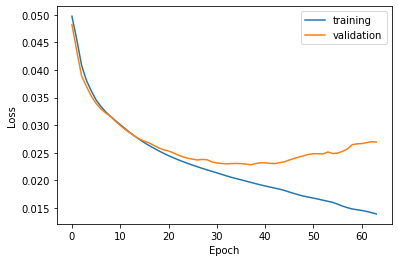

In [11]:
'''LSTM and Final model'''
#with possible use of 2 and 3 layer MLP transformations
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, MLP_layers = 1, layermlp1 = 128, layermlp2 = 128):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size       
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.MLP = MLP_layers       
        self.mlp1 = nn.Linear(hidden_size, layermlp1)
        self.mlp2 = nn.Linear(layermlp1, layermlp2)

        if MLP_layers == 1:
          self.fc = nn.Linear(hidden_size, num_classes)
        elif MLP_layers == 2:
          self.fc = nn.Linear(layermlp1, num_classes)
        else:
          self.fc = nn.Linear(layermlp2, num_classes)

        
    def forward(self, x):
        batch_size = x.size(0)
        

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 

        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.lstm(x.to(device), (hidden.to(device), c0.to(device)))

        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_size)


        #outputing depending on the MLP layers wanted
        if self.MLP == 2:
            out = self.mlp1(out)
            out = nn.functional.relu(out)
        elif self.MLP == 3:
            out = self.mlp1(out)
            out = nn.functional.relu(out)
            out = self.mlp2(out)
            out = nn.functional.relu(out)

        out = self.fc(out)
        
        return out
        
    def init_hidden(self, batch_size):
      # This method generates the first hidden state of zeros which we'll use in the forward pass
      # We'll send the tensor holding the hidden state to the device we specified earlier as well
      hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
      return hidden


def correct(y_pred, y):
  prediction_idx = torch.argmax(y_pred, dim=1)
  correct = torch.sum(prediction_idx == y)
  return correct


lstm_model = LSTM(input_size, hidden_size, num_layers, num_classes, mlp_layers, MLP1, MLP2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate) 

# Train the model
accuracies = []
accuracies_dev = []
accuracies_test = []
loss_training = []
loss_validation = []

for epoch in range(num_epochs):
  corrects_dev = 0
  corrects = 0
  loss2 = 0
  for iter_data in training_data:
    X = iter_data[:, :, :-1]
    Y = iter_data[:, :, -1]
    optimizer.zero_grad()
    X.to(device)
    output_training = lstm_model(X)   
    # output_training.to(device)
    corrects += correct(output_training, Y.view(-1).long().to(device))
    loss = criterion(output_training, Y.view(-1).long().to(device))     #loss = criterion(outputs, labels)
    loss.backward()  #Backpropagation
    optimizer.step()
    loss2 += loss
  loss_training.append(loss2)

  #validation loop on data 
  loss_dev2 = 0
  for iter_data in dev_data:
    X = iter_data[:, :, :-1]
    Y = iter_data[:, :, -1]
    output_dev = lstm_model(X).to(device)
    # output_dev = output_dev.cpu()
    corrects_dev += correct(output_dev, Y.view(-1).long().to(device))
    loss_dev = criterion(output_dev, Y.view(-1).long().to(device)).item()
    loss_dev2 += loss_dev
  loss_validation.append(loss_dev2)

#plot of validation and training loss
plt.plot(np.array(loss_training)/Data_length, label = 'training')
plt.plot(np.array(loss_validation)/dev_length, label = 'validation')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
''' Final accuracy on the training, validation, and test set.'''

#test accuracy
corrects_test = 0
for iter_data in test_data:
  X = iter_data[:, :, :-1]
  Y = iter_data[:, :, -1]
  output_test = lstm_model(X)
  output_test.to(device)
  corrects_test += correct(output_test, Y.view(-1).long().to(device))

accuracy = corrects/(Data_length * (sequence_length - 1))* 100
print('Training accuracy = {}%'.format(accuracy))

dev_accuracy = corrects_dev / (dev_length * (sequence_length - 1)) * 100
print('Validation accuracy = {}%'.format(dev_accuracy))

test_accuracy = corrects_test / (test_length * (sequence_length - 1)) * 100
print('Testing accuracy = {}%'.format(test_accuracy))


Training accuracy = 72.87130737304688%
Validation accuracy = 55.95063400268555%
Testing accuracy = 55.649261474609375%


In [13]:
''' Sentence creation ''' 

#creation of sentences
test_sentence1 = 'Your father is  '  
test_sentence2 = 'Hello, this is the end of books and art'
test_sentence3 = 'I am lacking inspiration '
test_sentence4 = 'Hello world '
test_sentence5 = 'Welcome to'


#one hot encoding it
def hot_encode(sentence):
  ohe = np.zeros([len(sentence), num_classes])
  for u in range(len(sentence)):    
    ohe[u, [char2val[char] for char in sentence][u]] = 1
  return ohe
#predict the end of a sentence
def predict_end_sentence(test_sentence, maxlength):
  ohe1 = hot_encode(test_sentence)
  char1 = torch.argmax(lstm_model(torch.Tensor(ohe1.reshape(1, len(ohe1), num_classes)))[-1]).item()

  while char1 not in (char2val['.'], char2val['?'], char2val['!']):
    if ohe1.shape[0] > maxlength:
      print('errorr')
      break
    # print(list(char2val.keys())[list(char2val.values()).index(char1)])
    test_sentence += list(char2val.keys())[list(char2val.values()).index(char1)]
    new_row = np.zeros(num_classes)
    new_row[char1] = 1
    ohe1 = np.vstack([ohe1, new_row])
    char1 = torch.argmax(lstm_model(torch.Tensor(ohe1.reshape(1, ohe1.shape[0], num_classes)))[-1]).item()

  return test_sentence + list(char2val.keys())[list(char2val.values()).index(char1)]

#call functions
print(predict_end_sentence(test_sentence1, 128))
print(predict_end_sentence(test_sentence2, 128))
print(predict_end_sentence(test_sentence3, 128))
print(predict_end_sentence(test_sentence4, 128))
print(predict_end_sentence(test_sentence5, 128))

Your father is  - it also how to make it .
Hello, this is the end of books and artificing and over-the-top .
I am lacking inspiration .
Hello world , but it is the execution it with a frighten , and the characters are not to be for the movie .
Welcome to the credits rarrelly light thriller .
